In [1]:
from platform import python_version
print(python_version())

3.8.5


In [1]:
import csv
import heapq
import itertools
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import pandas as pd
import pickle
import regex as re
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, make_scorer, roc_curve, auc, precision_recall_curve, average_precision_score, precision_score,classification_report, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import tensorflow_hub as hub 
import tensorflow as tf 
import time

nlp = spacy.load("en_core_web_sm")

/home/maz/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('./data/trials.csv', delimiter=',')
data.drop_duplicates(subset=['nctid','description','label'],keep='first',inplace=True)
data.head(25)

,nctid,description,label
0,NCT02464748,MND is often referred to as amyotrophic latera...,ALS
1,NCT00362362,OBJECTIVE:||The causes of sporadic motor neuro...,ALS
2,NCT03154450,Non-invasive ventilation (NIV) use in patients...,ALS
3,NCT03487263,The objectives of this study are to determine:...,ALS
4,NCT04454892,"With the development of supportive measures, t...",ALS
5,NCT02852278,The patient activities of daily living for amy...,ALS
6,NCT01776970,CANALS project has as a main objective to anal...,ALS
7,NCT01772602,The National ALS Registry's Research Notificat...,ALS
8,NCT01143428,Objective||Primary lateral sclerosis (PLS) and...,ALS
9,NCT02360891,This is a prospective observational multicentr...,ALS


In [4]:
def counts(sentence):
    sentence = sentence.split()
    #print(sentence)
    return len(sentence)

data['counts'] = data['description'].apply(lambda x : counts(x))
data.head(5)


,nctid,description,label,counts
0,NCT02464748,MND is often referred to as amyotrophic latera...,ALS,14
1,NCT00362362,OBJECTIVE:||The causes of sporadic motor neuro...,ALS,398
2,NCT03154450,Non-invasive ventilation (NIV) use in patients...,ALS,326
3,NCT03487263,The objectives of this study are to determine:...,ALS,172
4,NCT04454892,"With the development of supportive measures, t...",ALS,132


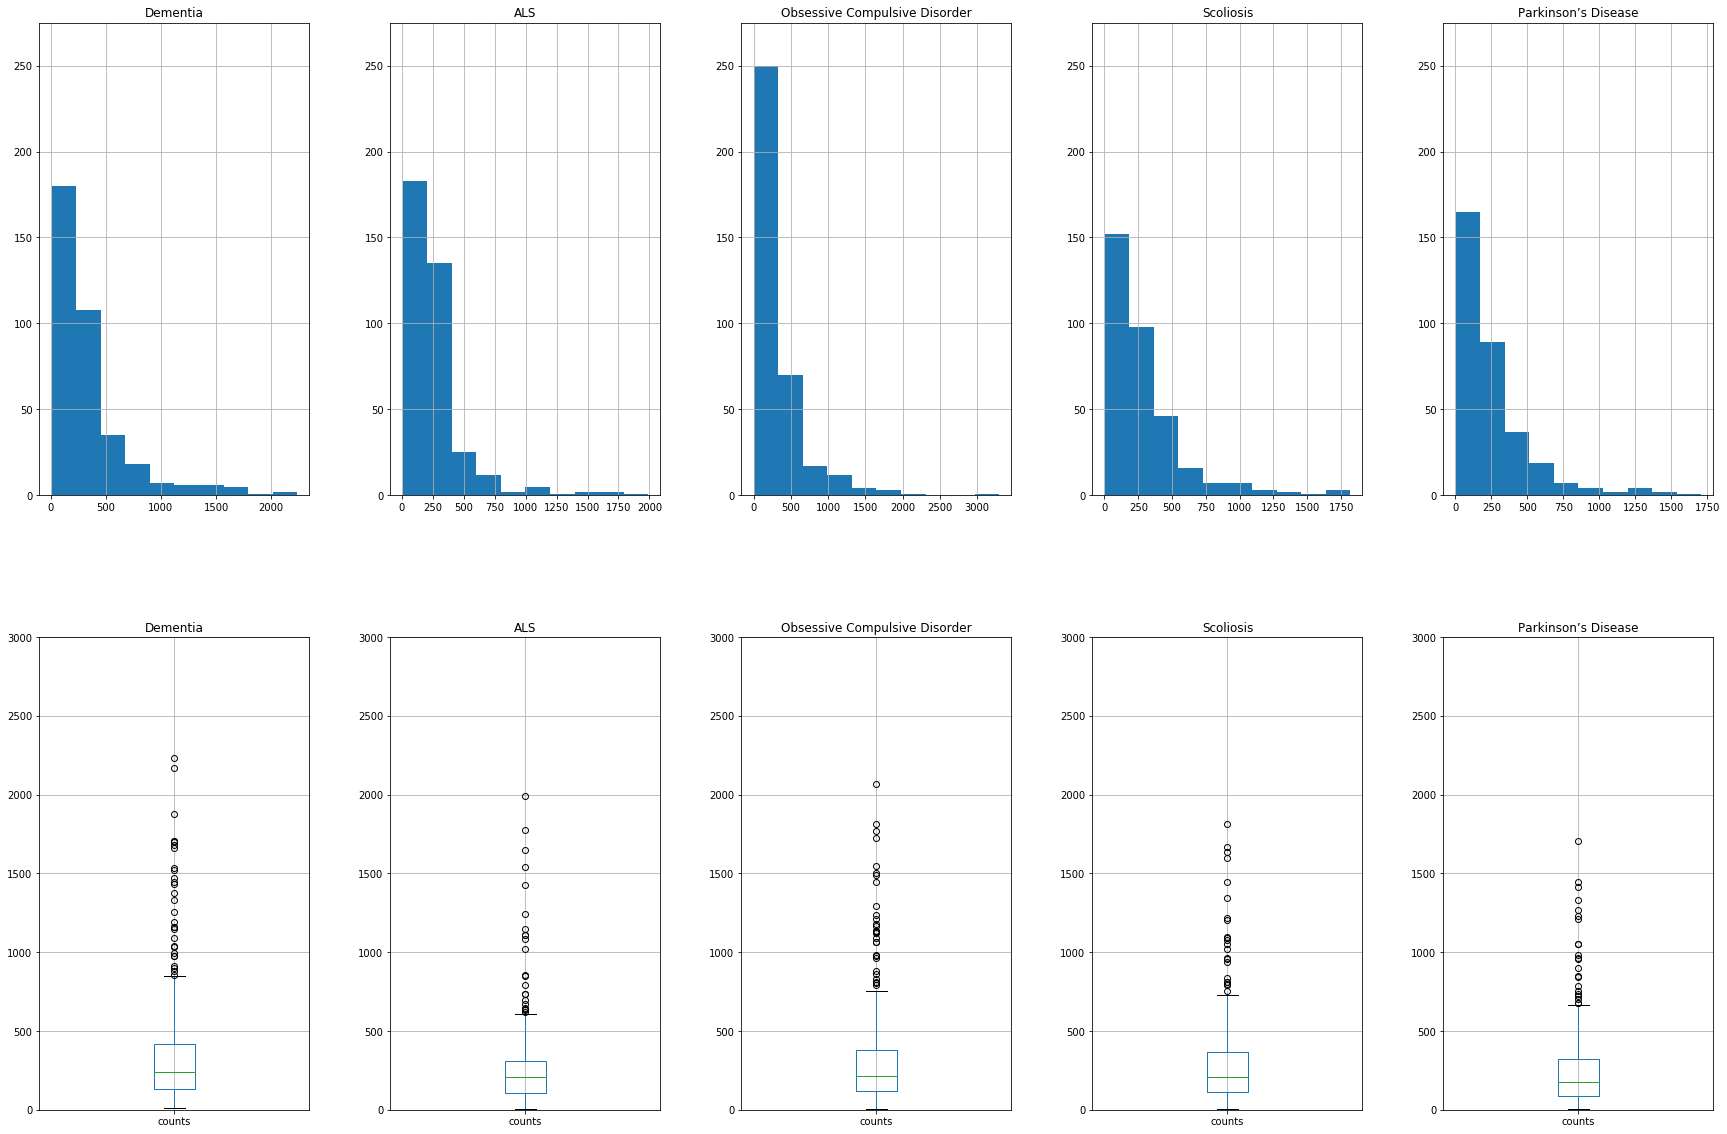

In [5]:
class_grouping = data.groupby("label")
columns = ['Dementia','ALS','Obsessive Compulsive Disorder','Scoliosis','Parkinson’s Disease']
fig, ax = plt.subplots(2,5)
fig.set_size_inches(30,20)
for index, a in enumerate(columns):
    class_grouping.get_group(a).hist(ax=ax[0][index],column='counts')
    class_grouping.get_group(a).boxplot(ax=ax[1][index],column=['counts'])
    ax[0][index].set_title(a)
    ax[1][index].set_title(a)
    ax[0][index].set_ylim(0,275)
    ax[1][index].set_ylim(0,3000)

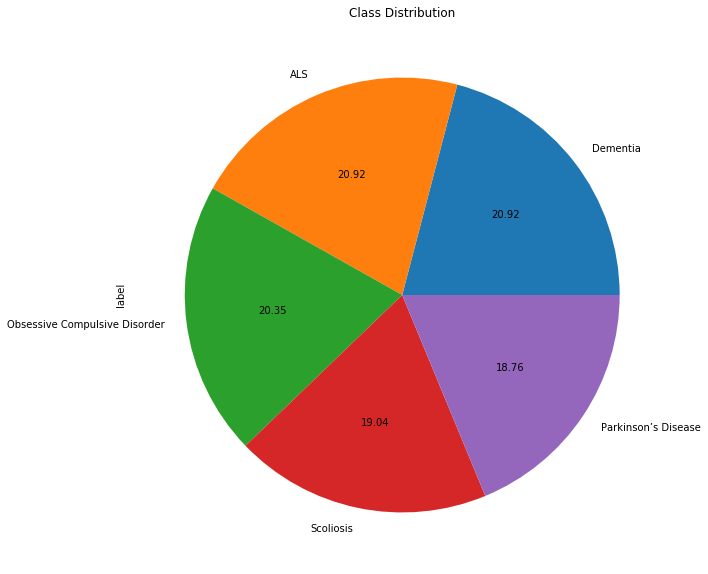

In [6]:
data['label'].value_counts(normalize=True).plot(kind='pie',autopct='%.2f',figsize=(10,10),title='Class Distribution')

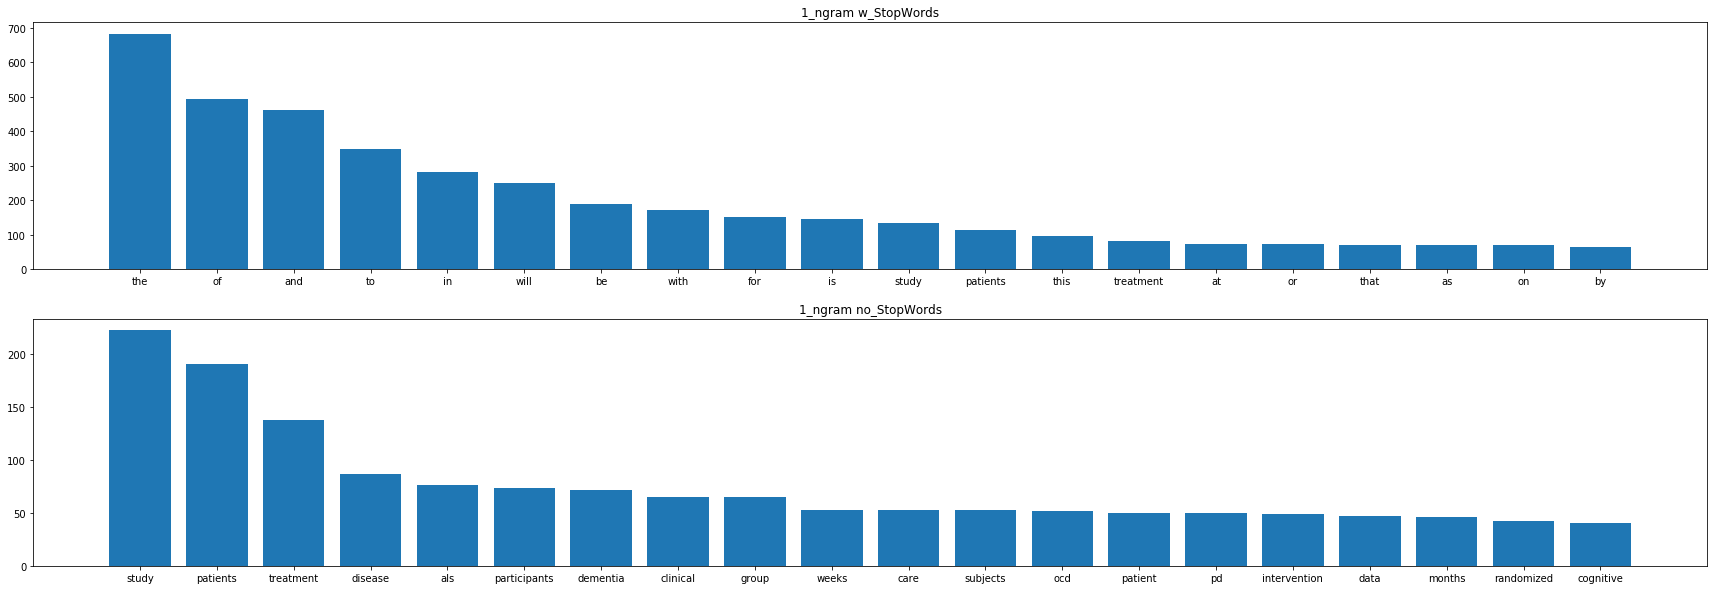

In [7]:
def top_n_grams(ngram,data,ax,number):
    tfidf_vec = TfidfVectorizer(ngram_range=(ngram,ngram),use_idf=False)
    tfidf_vec_nosw = TfidfVectorizer(ngram_range=(ngram,ngram),use_idf=False,stop_words='english')
    ngrams = tfidf_vec.fit_transform(data)
    ngrams_sum = ngrams.sum(axis=0)
    ngrams_nosw = tfidf_vec_nosw.fit_transform(data)
    ngrams_sum_nosw = ngrams_nosw.sum(axis=0)

    feature_names = np.array(tfidf_vec.get_feature_names())
    dicti_voc_ind = tfidf_vec.vocabulary_
    dicti_feature_tfidf_sum = {}
    count = 0
    for k,v in dicti_voc_ind.items():
        dicti_feature_tfidf_sum[k] = ngrams_sum[0,v]

    
    feature_names_nosw = np.array(tfidf_vec_nosw.get_feature_names())
    dicti_voc_ind_nosw = tfidf_vec_nosw.vocabulary_
    dicti_feature_tfidf_sum_nosw = {}
    count = 0
    for k,v in dicti_voc_ind_nosw.items():
        dicti_feature_tfidf_sum_nosw[k] = ngrams_sum_nosw[0,v]

    top20 = heapq.nlargest(number,dicti_feature_tfidf_sum.items(),key=lambda i: i[1])
    x,y = zip(*top20)
   # print(ax[0])

    ax[0].bar(list(x),list(y),align='center')
    ax[0].set_title('%d_ngram w_StopWords' % ngram)
    top20_nosw = heapq.nlargest(number,dicti_feature_tfidf_sum_nosw.items(),key=lambda i: i[1])
    x,y = zip(*top20_nosw)
    ax[1].bar(list(x),list(y),align='center')
    ax[1].set_title('%d_ngram no_StopWords' % ngram)
    
fig,ax = plt.subplots(2,1)
fig.set_size_inches(30,10)
top_n_grams(1,data['description'],ax,20)

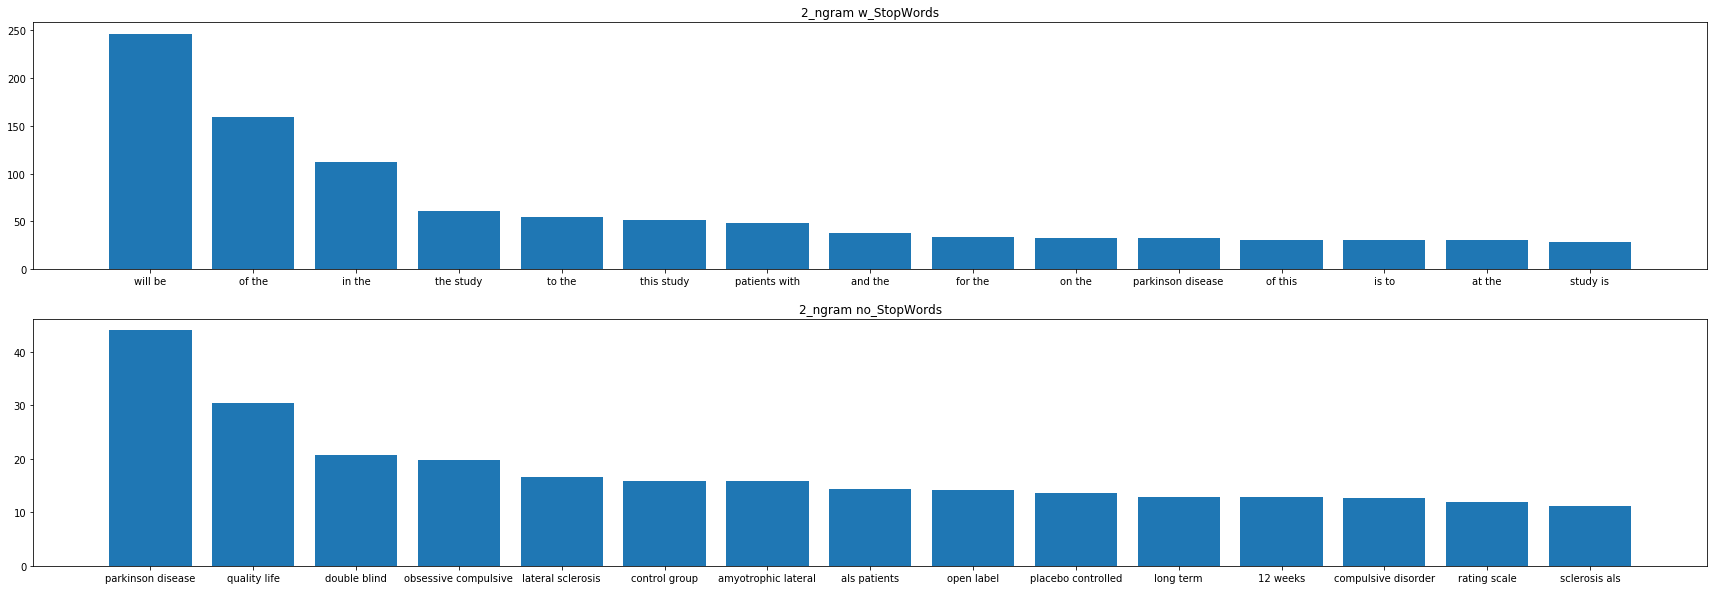

In [8]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(30,10)
top_n_grams(2,data['description'],ax,15)

In [9]:
embeddings_id = {}
with open('glove_emb/glove.6B.300d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        embeddings_id[word] = vector

In [10]:
def embed(sentence):
    sentence = sentence.split()
    M = []
    for w in sentence:
        try:
            M.append(embeddings_id[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v/np.sqrt((v**2).sum())

In [9]:
def normalizesentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'http\S+','',sentence)
    sentence = sentence.replace('-',' ')
    sentence = sentence.replace('|',' ')
    sentence = re.sub(r'[^A-Za-z\s]','',sentence)
    sentence = re.sub(r'\s+', ' ',sentence)
    nlp_output = nlp(sentence)
    lemma_sentence = []
    nosw_sentence = []
    nopunct_sentence = []

    for token in nlp_output:
        if token.is_punct or token.lemma_ =="'s":
            continue
        if token.is_stop == False:
            nosw_sentence.append(token.lemma_)
        
        lemma_sentence.append(token.lemma_)
        nopunct_sentence.append(token.text)
    

    return ' '.join(lemma_sentence), ' '.join(nosw_sentence), ' '.join(nopunct_sentence)

encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])
with open('encoder.pk','wb') as f:
    pickle.dump(encoder,f)

class_transform_dict = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))

In [10]:
data['lemma'], data['lemma_no_sw'], data['no_punct'] = zip(*data['description'].apply(lambda x : normalizesentence(x)))
#print(data.head(5))

In [13]:
data['embeddings'] = data['lemma_no_sw'].apply(lambda x: embed(x))

In [11]:
def clf_analyse(list_data,target,clf,ngram,modelname,savemodel,version):

       
    list_labels = list(encoder.inverse_transform([0,1,2,3,4]))
    roc_auc = {}
    

    scoring = {'precision': make_scorer(precision_score,average='macro'), 'recall': make_scorer(recall_score, average='macro')}

    colours = ['orange','green','blue','red','darkblue']
    fig,ax = plt.subplots(3,3)
    fig.set_size_inches(30,25)

    for a in list(range(0,len(list_data))):
        data = list_data[a]

        if a <= 2:
            tfidf_vec = TfidfVectorizer(ngram_range=(ngram,ngram),use_idf=True)
            X_train, X_val, y_train, y_val = train_test_split(data,target[a],test_size=0.2,random_state=0)
            X_train = tfidf_vec.fit_transform(pd.Series(X_train))
        else:
            X_train, X_val, y_train, y_val = train_test_split(data,target[a],test_size=0.2,random_state=0)
            print(X_train.shape)
            X_train = X_train.to_numpy().reshape(-1,1)

            

        scores = cross_validate(clf,X_train,y_train,scoring=scoring,cv=5)
        if a == 0:
            dataname = 'raw'
        elif a == 1:
            dataname = 'lemma'
        elif a == 2:
            dataname = 'lemma_no_sw'
        elif a == 3:
            dataname = 'sentence_emb'


        recall_macro = np.mean(scores['test_recall'])
        precision_macro = np.mean(scores['test_precision'])


        harmonic_mean = 2*recall_macro*precision_macro / (recall_macro+precision_macro)


        print("Generalisation of %s-model Recall: %.3f, Precision: %.3f, F1: %.3f " % (dataname,recall_macro,precision_macro,harmonic_mean))

        clf.fit(X_train,y_train)
        if savemodel and a == version:
            with open(modelname+'.pk','wb') as f:
                pickle.dump(clf,f)
                
            with open('vectorizer.pk','wb') as f:
                pickle.dump(tfidf_vec,f)
                
            
        X_val = tfidf_vec.transform(pd.Series(X_val))
        try:
            y_score = clf.decision_function(X_val)
            to_plot = True
        except:
            to_plot = False

        y_predict = clf.predict(X_val)
        clf_report = classification_report(y_val,y_predict,output_dict=True,target_names=list_labels)

        precision = {}
        recall = {}
        average_precision = {}


        if to_plot:
            for i in list(range(0,4)):
                precision[i],recall[i],_ = precision_recall_curve(y_val,y_score[:,i],pos_label=i) 


        plot_confusion_matrix(clf,X_val,y_val,normalize='true',ax=ax[0,a],display_labels=list_labels,cmap=plt.cm.Blues)

        ax[0][a].set_title("Dataset %s" % dataname)
        sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:].T,annot=True,ax=ax[1][a],cmap="Blues",cbar_kws={"orientation": "horizontal"})
        bottom,top = ax[1][a].get_ylim()
        ax[1][a].set_ylim(bottom+0.5,top-0.5)
       # ax[1][a].set_title("Confusion Matrix")

        if to_plot:

            f_scores = np.linspace(0.2,0.8,num=4)
            lines = []
            labels = []
            for f_score in f_scores:
                x = np.linspace(0.01,1)
                y = f_score * x/(2*x - f_score)
                l, = ax[2,a].plot(x[y>=0], y[y>=0], color = 'gray', alpha = 0.2)
                ax[2,a].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] +0.02))

            lines.append(l)
            #labels.append('iso-f1 curves')

            for i in list(range(0,4)):    
                ax[2,a].plot(recall[i],precision[i],linestyle='--',color=colours[i],label='Precision-Recall for class {0} (Area = {1:0.2f})'''.format(list_labels[i],auc(recall[i],precision[i])))
        #      print('color and label %s %s' % (colours[i],list_labels[i]))
            # labels.append()
            ax[2,a].set_xlabel('Recall')
            ax[2,a].set_ylabel('Precision')
            ax[2,a].legend(loc='best')
            ax[2,a].set_ylim([0.0,1.05])
            ax[2,a].set_xlim([0.0,1.0])
            ax[2,a].set_title("Dataset %s" % dataname)




In [12]:
new_data = data[data.counts > 10]

target = [new_data['label'],new_data['label'],new_data['label']]#,new_data['label']]
list_data = [new_data['no_punct'],new_data['lemma'],new_data['lemma_no_sw']]#new_data['embeddings']]

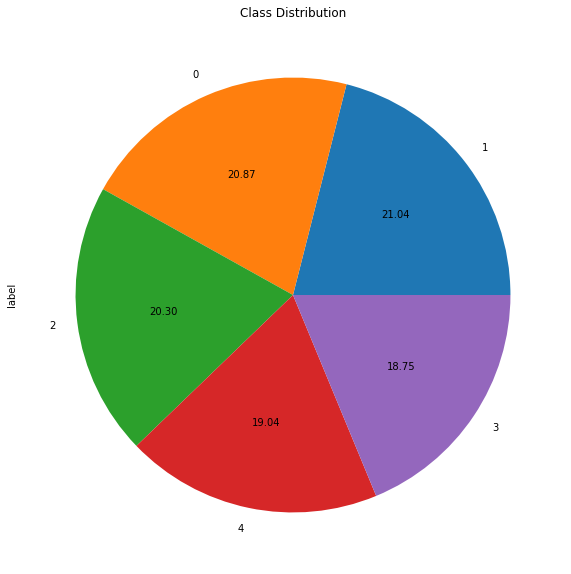

In [13]:
new_data['label'].value_counts(normalize=True).plot(kind='pie',autopct='%.2f',figsize=(10,10),title='Class Distribution')

Generalisation of raw-model Recall: 0.772, Precision: 0.795, F1: 0.783 
Generalisation of lemma-model Recall: 0.743, Precision: 0.797, F1: 0.769 
Generalisation of lemma_no_sw-model Recall: 0.758, Precision: 0.794, F1: 0.776 


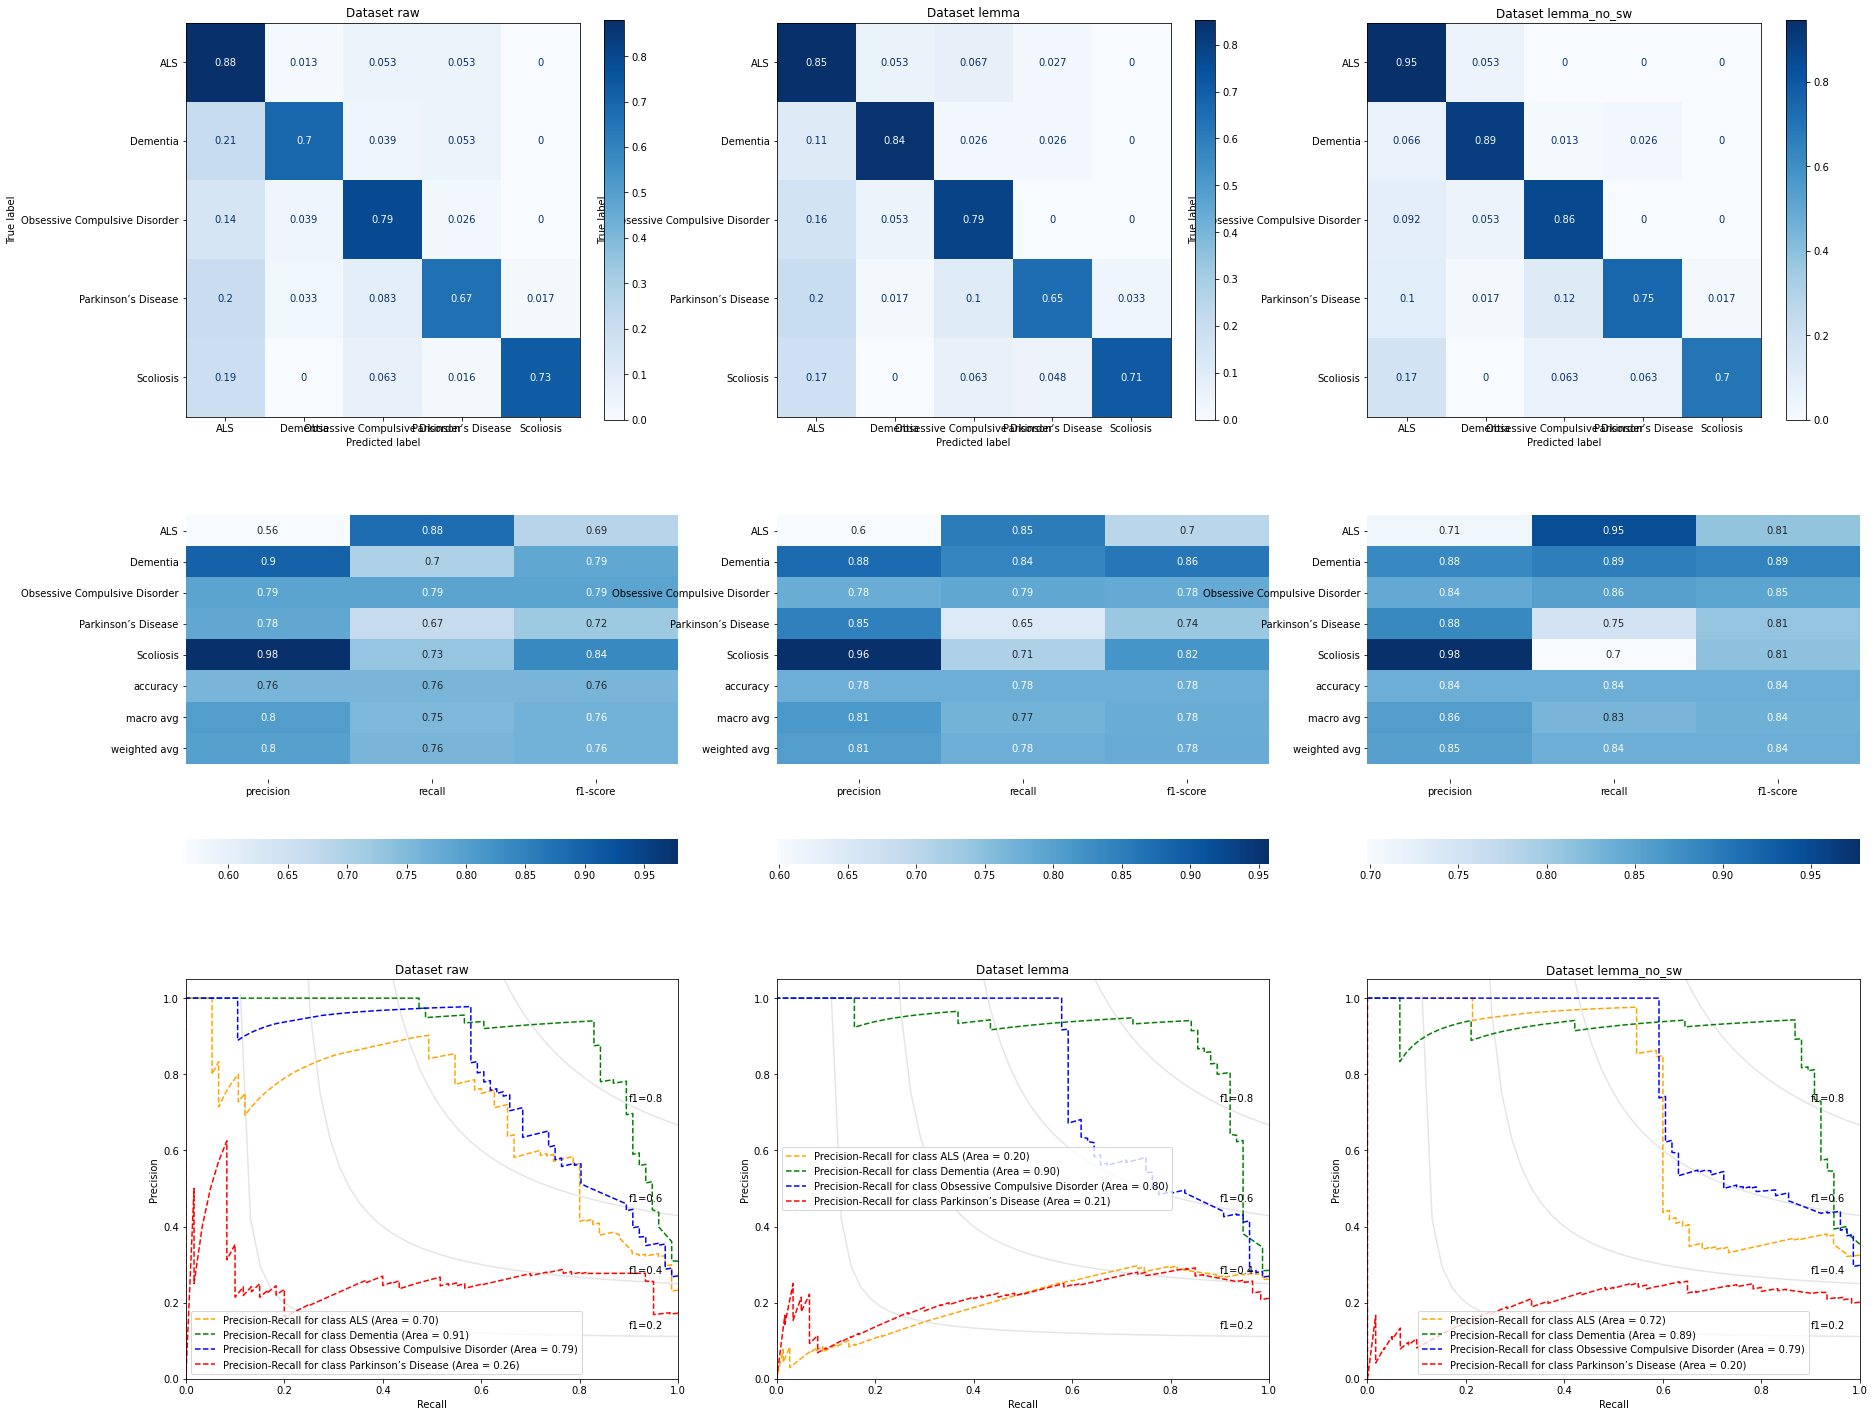

In [17]:
clf = AdaBoostClassifier(random_state=0)
clf_analyse(list_data,target,clf,1,'adaboost',False,0)

Generalisation of raw-model Recall: 0.920, Precision: 0.920, F1: 0.920 
Generalisation of lemma-model Recall: 0.920, Precision: 0.921, F1: 0.921 
Generalisation of lemma_no_sw-model Recall: 0.924, Precision: 0.925, F1: 0.924 


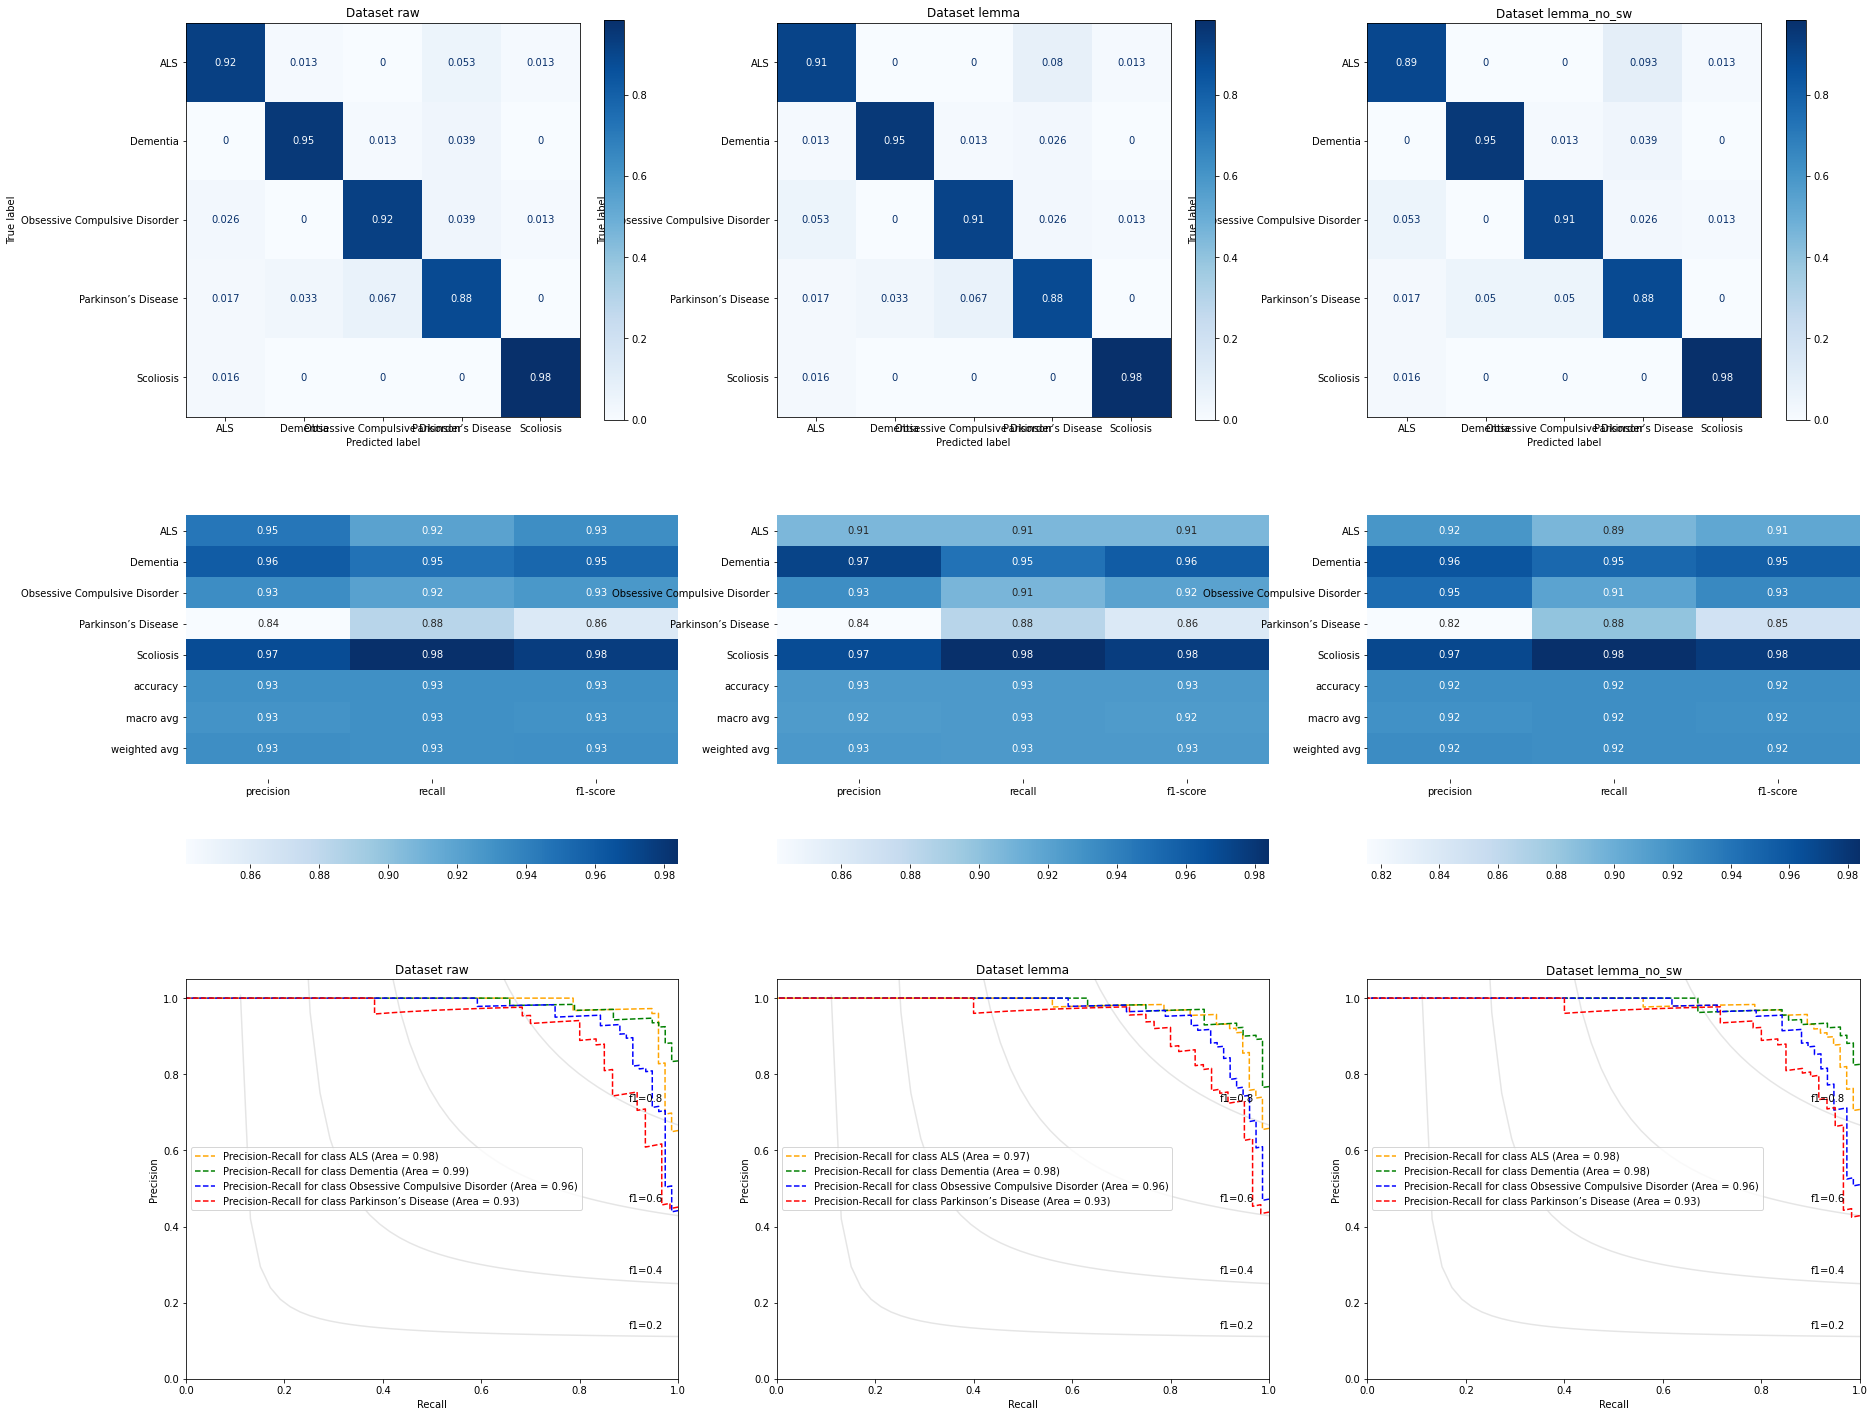

In [19]:
clf = LogisticRegression(random_state=0,max_iter=400,class_weight='balanced')
clf_analyse(list_data,target,clf,1,'logistic_',True,0)

Generalisation of raw-model Recall: 0.915, Precision: 0.917, F1: 0.916 
Generalisation of lemma-model Recall: 0.919, Precision: 0.921, F1: 0.920 
Generalisation of lemma_no_sw-model Recall: 0.921, Precision: 0.924, F1: 0.923 


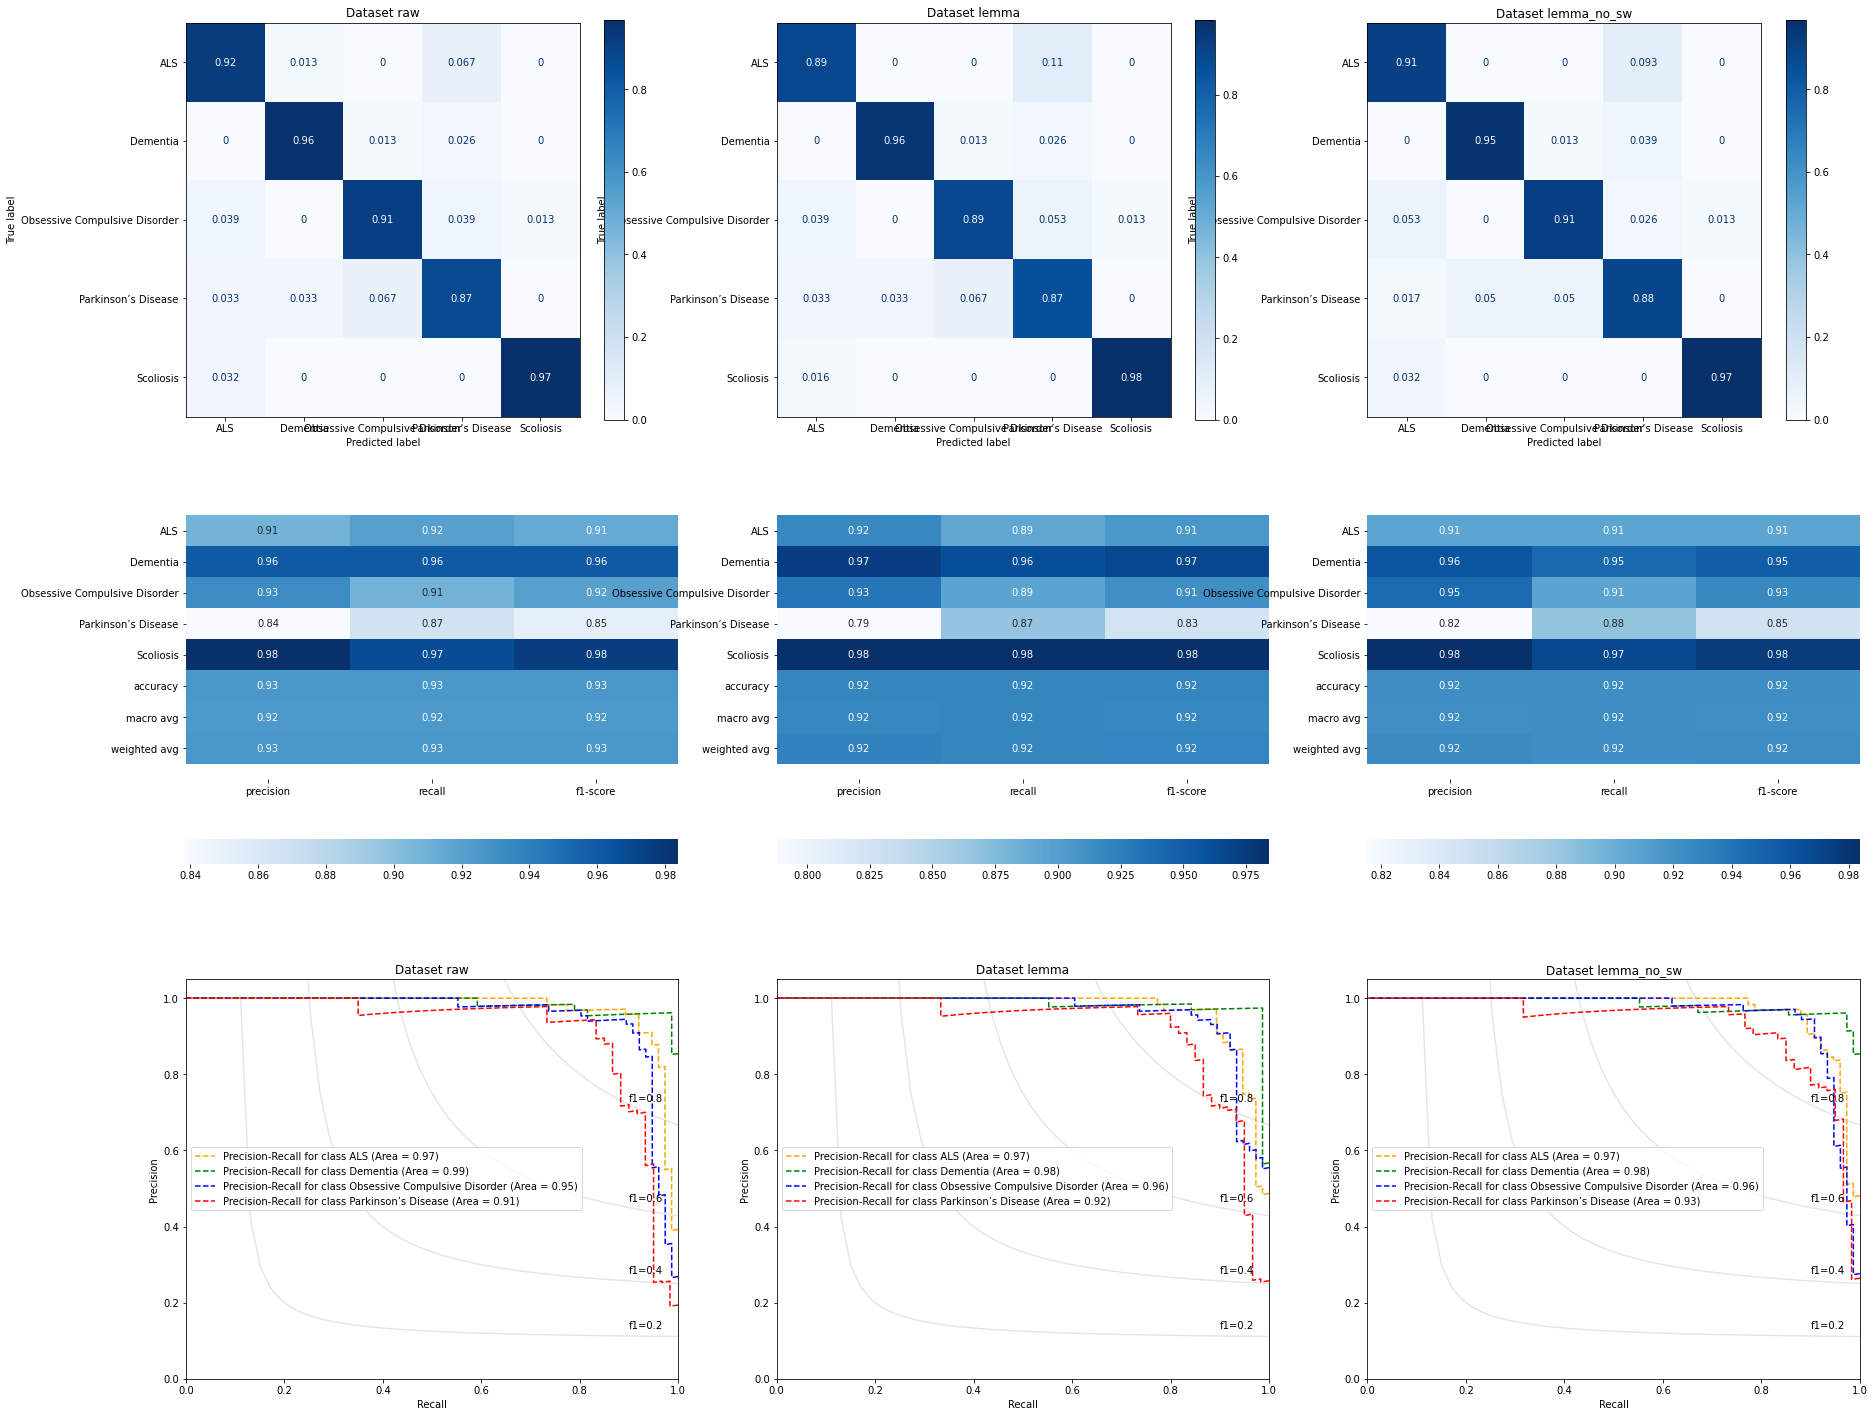

In [18]:
clf = SVC(random_state=0)
clf_analyse(list_data,target,clf,1,'svm',False,0)

In [20]:
vect = CountVectorizer()
x = vect.fit_transform(new_data['no_punct'])
vocab_size = len(vect.get_feature_names())
encoded_text = new_data['no_punct'].apply(lambda x: one_hot(x,vocab_size))
p_encoded_text = pad_sequences(encoded_text,maxlen=max(new_data['counts']),padding='post')
X_train, X_val, y_train, y_val = train_test_split(p_encoded_text,target[0],test_size=0.2,random_state=0)

In [22]:
model = Sequential()
embedding_layer = Embedding(input_dim=vocab_size,output_dim=10,input_length=max(new_data['counts']))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(5,return_sequences=True)))
model.add(Bidirectional(LSTM(5,return_sequences=False)))
model.add(Dense(6,activation='softmax'))
model.add(Dense(1,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4a67738820>>

In [23]:
model_2 = Sequential()
embedding_layer = Embedding(input_dim=vocab_size,output_dim=10,input_length=max(new_data['counts']))
model_2.add(embedding_layer)
#model_2.add(Bidirectional(LSTM(2,return_sequences=True)))
model_2.add(LSTM(10,return_sequences=False))
#model_2.add(Dense(6,activation='softmax'))
model_2.add(Dense(1,activation='softmax'))
model_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model_2.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4a67772a30>>

Epoch 1/10
44/44 [==============================] - 226s 5s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_1: 0.7927 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_1: 0.7857 - val_recall_1: 1.0000
Epoch 2/10
44/44 [==============================] - 217s 5s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_1: 0.7927 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_1: 0.7857 - val_recall_1: 1.0000
Epoch 3/10
44/44 [==============================] - 218s 5s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_1: 0.7927 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_1: 0.7857 - val_recall_1: 1.0000
Epoch 4/10
44/44 [==============================] - 216s 5s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_1: 0.7927 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_1: 0.7857 - val_recall_1: 1.0000
Epoch 5/10
44/44 [==============================] - 215s 5s/step - loss: 0.0000e+00 

Text(0.5, 0, 'epoch')

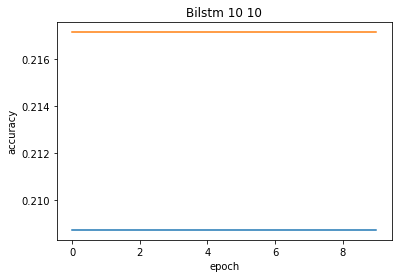

In [25]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_val,y_val))
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
bb = history.history['val_acc']
precision = [val for key,val in history.history.items() if 'val_precision' in key]
recall = [val for key,val in history.history.items() if 'val_recall' in key]
plt.title('Bilstm 10 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#stringtext = "Precision: %.2f, Recall: %.2f" % (precision[0][])

Epoch 1/10
44/44 [==============================] - 101s 2s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_2: 0.7927 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_2: 0.7857 - val_recall_2: 1.0000
Epoch 2/10
44/44 [==============================] - 107s 2s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_2: 0.7927 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_2: 0.7857 - val_recall_2: 1.0000
Epoch 3/10
44/44 [==============================] - 109s 2s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_2: 0.7927 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_2: 0.7857 - val_recall_2: 1.0000
Epoch 4/10
44/44 [==============================] - 100s 2s/step - loss: 0.0000e+00 - acc: 0.2087 - precision_2: 0.7927 - recall_2: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.2171 - val_precision_2: 0.7857 - val_recall_2: 1.0000
Epoch 5/10
44/44 [==============================] - 99s 2s/step - loss: 0.0000e+00 -

Text(0.5, 0, 'epoch')

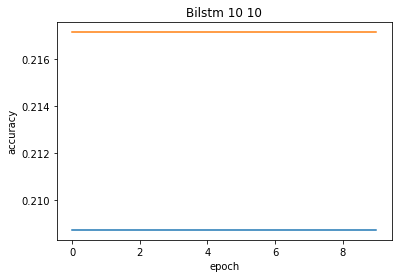

In [27]:
history = model_2.fit(X_train,y_train,epochs=10,validation_data=(X_val,y_val))
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
bb = history.history['val_acc']
precision = [val for key,val in history.history.items() if 'val_precision' in key]
recall = [val for key,val in history.history.items() if 'val_recall' in key]
plt.title('Bilstm 10 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')